# Dask & OME-Zarr
Chunk-wise Volumetric Image Processing

In [1]:
from dask.distributed import Client
import dask.array as da
import zarr
import dask
import matplotlib.pyplot as plt
from ome_zarr.io import parse_url
from ome_zarr.reader import Reader
from ome_zarr.io import ZarrLocation
from dask_image.ndfilters import uniform_filter
import numpy as np

# Start Dask client

In [2]:
# Start Dask client with memory limit
client = Client(n_workers=10, memory_limit="1GB")

In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 20,Total memory: 9.31 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44737,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:43739,Total threads: 2
Dashboard: http://127.0.0.1:41113/status,Memory: 0.93 GiB
Nanny: tcp://127.0.0.1:46253,


# OME-Zarr data input and output

In [4]:
scale = 2 # Use 0 for original resolution
input_path = '/dtu/3d-imaging-center/QIM/QIM_sandbox/fima/OpticalNerve.zarr/'
output_path = f"/dtu/3d-imaging-center/QIM/QIM_sandbox/fima/OpticalNerve_Output_Scale{scale}.zarr"

## Check input

In [5]:
# Load the OME-Zarr input file
location = ZarrLocation(input_path)
reader = Reader(location)
nodes = list(reader())
image_node = nodes[0]
data = image_node.data[scale] 

data

dask.array<from-zarr, shape=(1024, 1033, 1033), dtype=uint16, chunksize=(100, 100, 100), chunktype=numpy.ndarray>

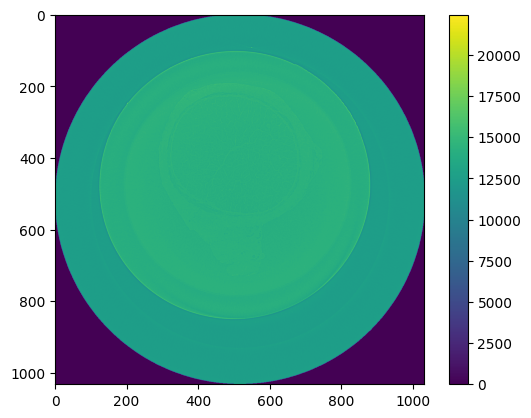

In [6]:
middle_slice = data.shape[0]//2

plt.imshow(data[middle_slice])
plt.colorbar()
plt.show()

# Operations on volume

In [7]:
# Apply operations on the volume
output = data

#thesholds
min_value = 14000
max_value = 15000
output = np.clip(output, min_value , max_value)

# Drawn cube in the middle of the volume
size = 75
output[(data.shape[0])//2-size:(data.shape[0])//2+size, 
       (data.shape[1])//2-size:(data.shape[1])//2+size, 
       (data.shape[2])//2-size:(data.shape[2])//2+size] = max_value

# Dask viz of output
output

dask.array<setitem, shape=(1024, 1033, 1033), dtype=uint16, chunksize=(100, 100, 100), chunktype=numpy.ndarray>

# Process operations

In [8]:
# Save the result to Output.zarr
output.to_zarr(output_path, component='output', overwrite=True)
print('Saved thresholded data to Output.zarr')

Saved thresholded data to Output.zarr


# Check results

In [9]:
# Open the Zarr store directly
output_store = zarr.DirectoryStore(output_path)
output_group = zarr.open(output_store, mode='r')

# Load the thresholded dataset as a Dask array
data_output = da.from_zarr(output_group['output'])
data_output

dask.array<from-zarr, shape=(1024, 1033, 1033), dtype=uint16, chunksize=(100, 100, 100), chunktype=numpy.ndarray>

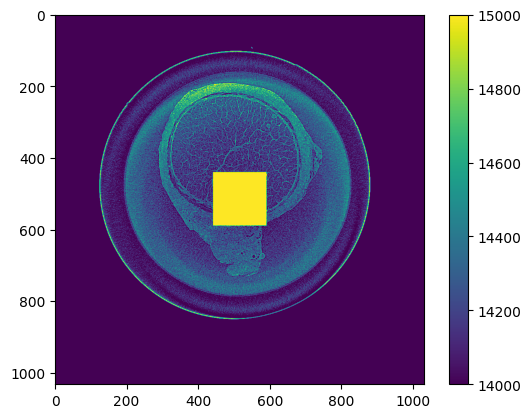

In [10]:
plt.imshow(data_output[middle_slice])
plt.colorbar()
plt.show()